## Predicting User Knowledge Levels

DSCI 100 - Project Group 40

Members: Sam Kao, Namya Sharma, Yulu Duan, Jason Zhou

### Introduction

The User Knowledge dataset contains a total of 403 observations and covers a total of six variables, including a single categorical variable and the remaining five variables as numerical doubles. The variables within the dataset are: STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), PEG (The exam performance of user for goal objects), and UNS (categorical variable; an individual’s knowledge level). The goal object in this dataset refers to a user’s knowledge on electrical DC machines (Masrofin, 2019). Hence in this case, the exam performance of the goal objects refers to the standardized test scores that a student receives on an examination based on the topic of electrical machines.

Within this report, we will use the User Knowledge dataset to create a K-nearest neighbours classifier in order to answer our question, as follows: 

**Question:** What will the knowledge level (UNS) of an individual be based on their exam performance of the goal object (PEG)? 

Such a classifier can be the next step in helping recruiters select the best applicants for job positions by helping them categorize candidates’ knowledge levels and thus help sort through numerous applicants efficiently. 

### Methods

To build our model, we will be using the K-nearest neighbours algorithm which operates by computing the Euclidean (straight-line) distance between a new observation and all the other observations in the training dataset and uses the majority label of the “K”-nearest points to the unlabeled observation (Timbers et al., 2021). We begin by distinguishing the training and testing sets within the User Knowledge dataset and ensuring the variables are the correct data types before using solely the training set to tune our model. We created a recipe where we utilized the functions to scale and center the variables and then built a model specification by using the nearest_neighbours function and setting the engine and mode to “kknn” and “classification” respectively. To choose the optimal “K” nearest neighbour value, we conducted cross validation by splitting the training dataset into 5 folds and testing out K values from 1-100. By creating a plot of the K value vs its relative accuracy, we were able to determine that the best K for our model was at K=16 as it provided the highest accuracy value at 84%. We retrained the model using K=16 and fitted the model to the training dataset. We then determined the accuracy of the final product by using the trained model to predict the labels on the testing dataset and obtained an accuracy value of 86%. Our group also wanted to visualize the user knowledge predictions made by our model, hence we created four completely new PEG values unseen by our model and plotted these values as straight horizontal lines on a bar graph with the averages of the different knowledge classes on the x-axis. By observing which knowledge “bar” the observation crossed first, we visualized which knowledge label it would be classified as. 

### Exploratory Data Analysis

In [1]:
# loading the necessary libraries for our analysis
# Setting the seed, so the result should be the same for each run
set.seed(1)
library(tidyverse)
library(tidymodels)
library(readxl)
library(dplyr)
library(gridExtra)
library(magrittr)
library(tibble)
library(yardstick)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Reading the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) # sheet 2 => training data
testing_data <- read_excel("data.xls", sheet = 3) # sheet 3 => testing data


# Select only the columns we need and making our class as a factor
training_data <- training_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

testing_data <- testing_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

# We noticed that the testing data and training data have varying lables. In the testing data
# the label for very low UNS is present as 'Very Low' however this same label is presented as 'very_low'
# in the training data. For this reason, we need to match the labels, otherwise the accuracy can't be predicted.
# We then have to make the column into a fct class again
testing_data <- testing_data %>%
    mutate_at('UNS', str_replace, 'Very Low', 'very_low') %>%
    mutate(UNS = as_factor(UNS))

# view the dataframe to make sure it is processed properly
training_data
testing_data

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


In [3]:
# Summarize the training data, counting how many occurences of each class
set.seed(1)
num_of_class <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    count(UNS)

# preliminary analysis
num_of_class

UNS,n
<fct>,<int>
High,63
Middle,88
Low,83
very_low,24


In [4]:
# Computing the means of the predictor variables in dataset
set.seed(1)
predictors_mean <- training_data %>%
                  summarize (mean_STG = mean(STG, na.rm = TRUE),
                             mean_SCG = mean(SCG, na.rm = TRUE),
                             mean_STR = mean(STR, na.rm = TRUE),
                             mean_LPR = mean(SCG, na.rm = TRUE),
                             mean_PEG = mean(PEG, na.rm = TRUE))
# preliminary analysis
predictors_mean

mean_STG,mean_SCG,mean_STR,mean_LPR,mean_PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.3556744,0.4585388


In [5]:
# Finding rows of missing data
set.seed(1)
missing_data <- training_data %>% 
        filter(is.na(STG), is.na(PEG), is.na(SCG), is.na(STR), is.na(LPR), is.na(UNS)) %>%
        nrow()

# see how many rows of missing data there are
missing_data

[1] 0

In [7]:
# Compare the distributions of each of the predictor variables you plan to use in your analysis
# The distribution of exam performace of goal objects (PEG)
set.seed(1)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_PEG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>% 
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Exam performance of goal objects", fill = "The knowledge level of user")+
    ggtitle("FIGURE 1 <- PEG vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [8]:
# Compare the distributions of each of the predictor variables you plan to use in your analysis
# The distribution of the degree of study time for goal object materails (STG)
set.seed(1)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_STG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Study time for goal object materails", fill = "The knowledge level of user")+
    ggtitle("FIGURE 2 <- STG vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [9]:
# Compare the distributions of each of the predictor variables you plan to use in your analysis
# The degree of repetition number of user for goal object materials (SCG)
set.seed(1)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_SCG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = SCG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Degree of repition for goal object materails", fill = "The knowledge level of user")+
    ggtitle("FIGURE 3 <- SCG vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [10]:
# Compare the distributions of each of the predictor variables you plan to use in your analysis
# The degree of study time of user for related objects with goal object (STR)
set.seed(1)
options(repr.plot.width = 10, repr.plot.height = 10) 
distr_STR <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STR, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Degree of study time for goal object materails", fill = "The knowledge level of user")+
    ggtitle("FIGURE 4 <- STR vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [11]:
# Compare the distributions of each of the predictor variables you plan to use in your analysis
# The exam performance of user for related objects with goal object (LPR)
set.seed(1)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_LPR <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = LPR, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Exam performance of related object", fill = "The knowledge level of user")+
    ggtitle("FIGURE 5 <- LPR vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


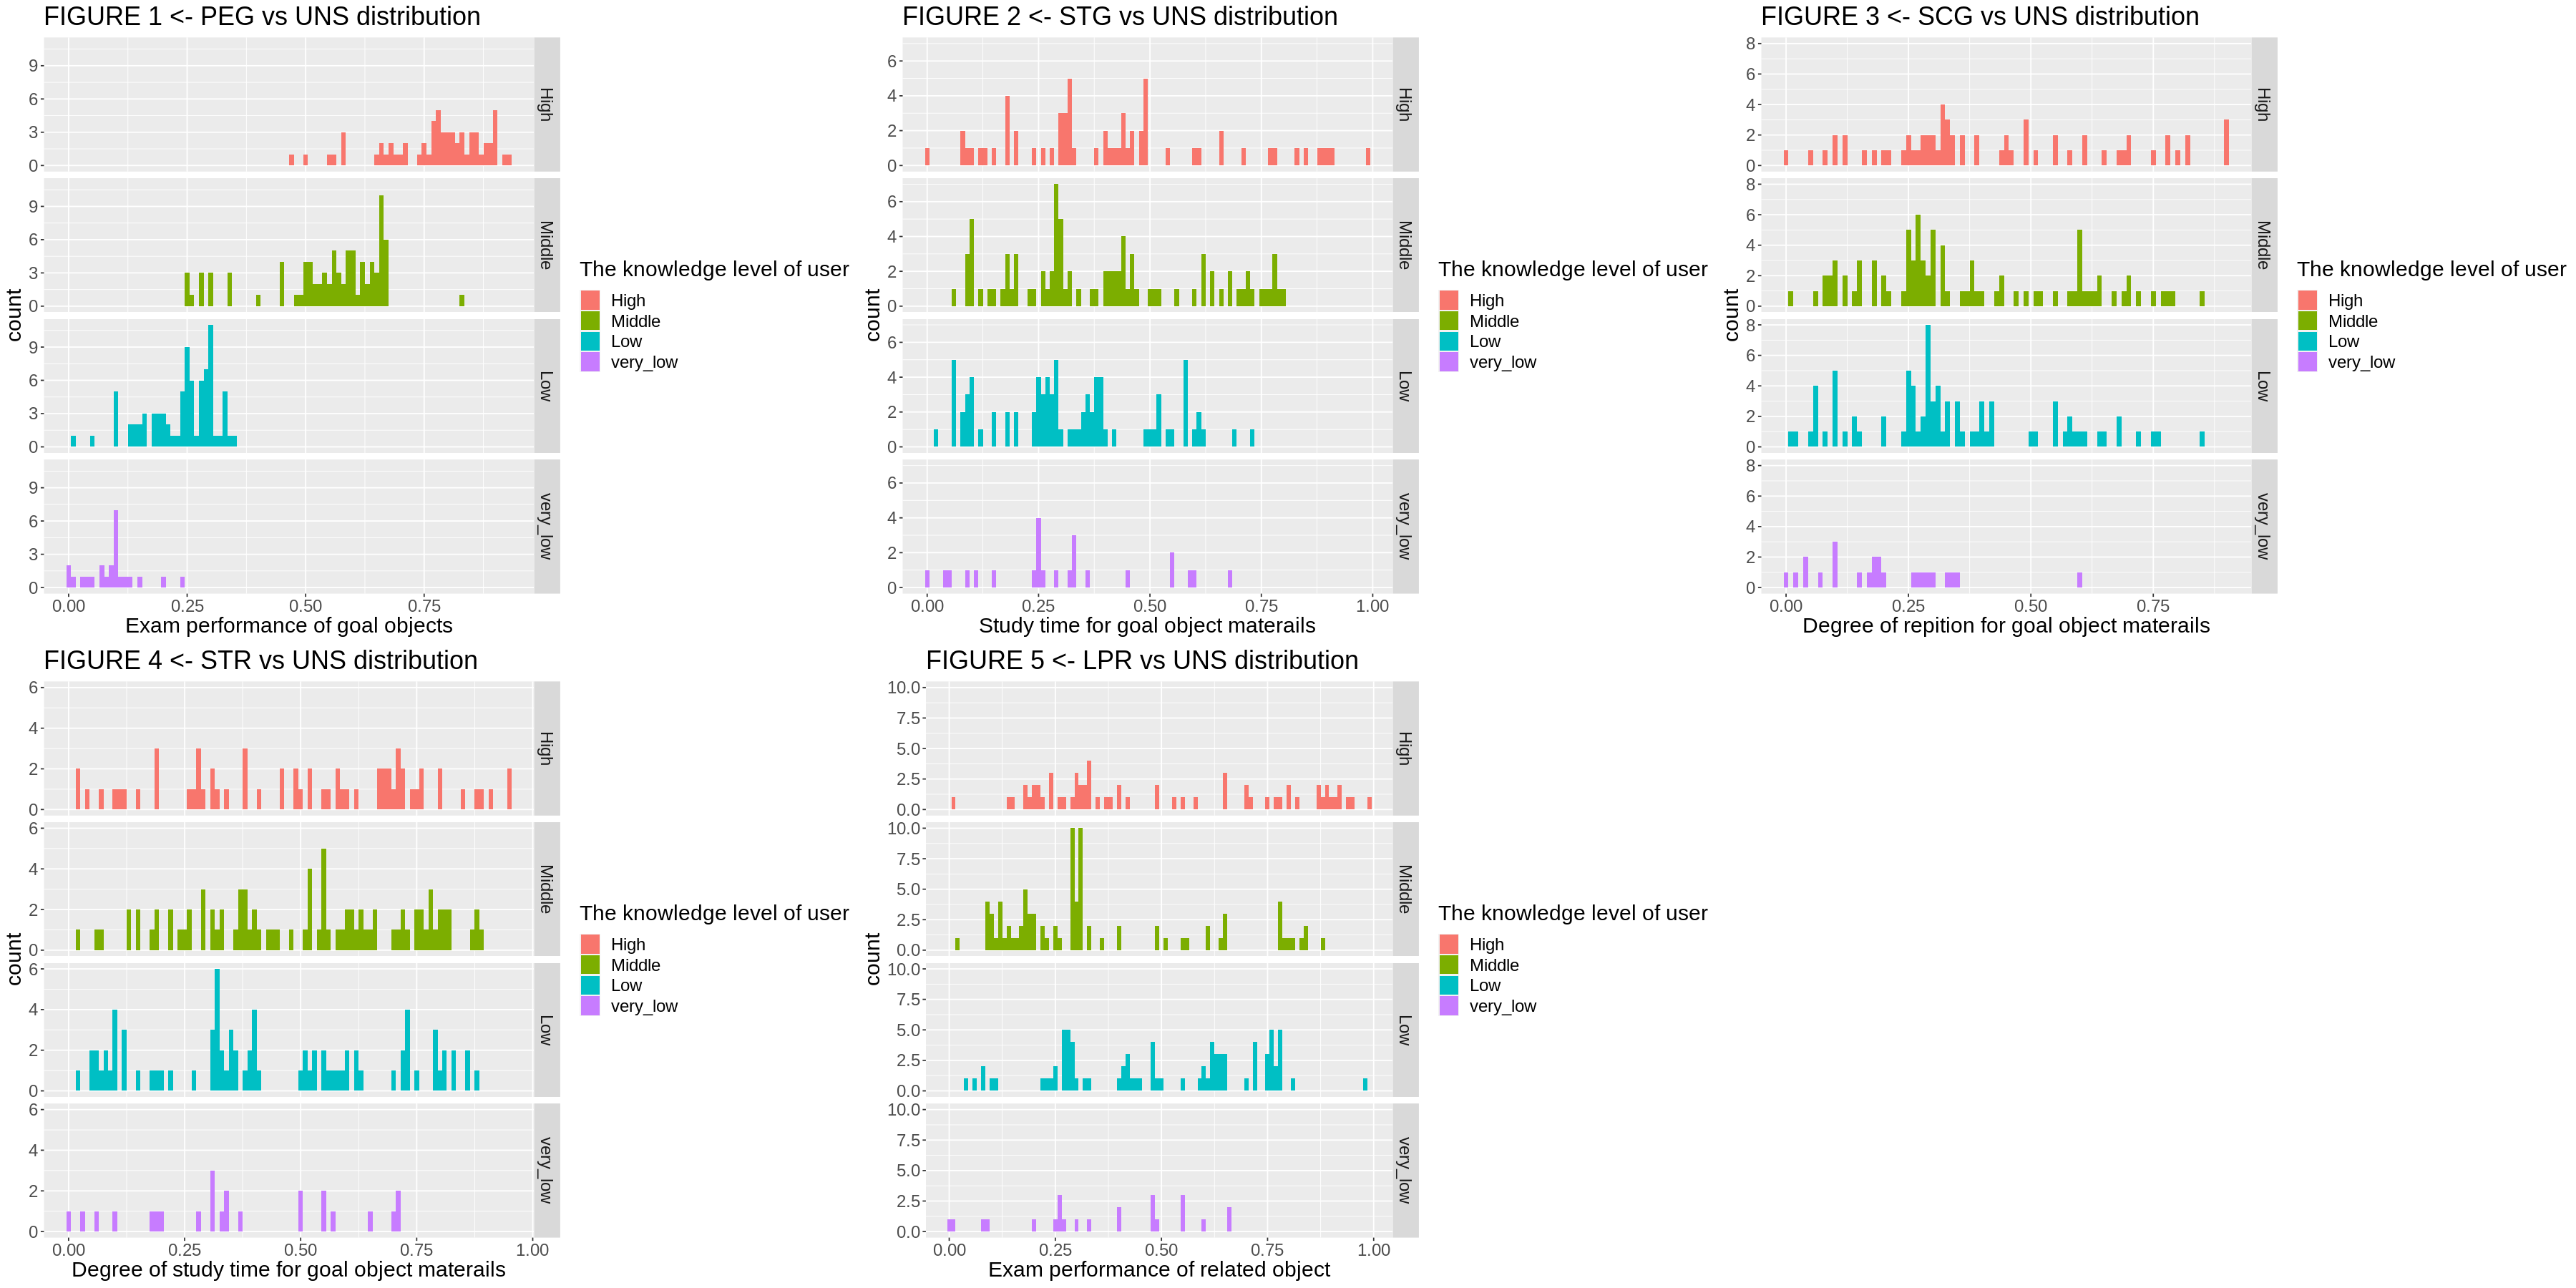

In [12]:
# Side-by side comparison of the distributions of each of the predictor variables in the dataset
set.seed(1)
library(cowplot)
options(repr.plot.width = 30, repr.plot.height = 15)
plot_grid(distr_PEG, distr_STG, distr_SCG, distr_STR, distr_LPR)
options(repr.plot.width = 30, repr.plot.height = 15)

### Building K-NN Model

In [14]:
set.seed(1)
# Scale and center our data
data_recipe <- recipe(UNS ~ PEG, data = training_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

# Create the K-nn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_spec

# Split the training data into 5 folds
data_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [15]:
set.seed(1)
# Set up different K values to test during cross validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# Combine in a workflow, collect metrics from cross validation
knn_results <- workflow() %>%
  add_recipe(data_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = data_vfold, grid = k_vals) %>%
  collect_metrics()

# Obtain accuracy values for different K values from metrics
accuracies <- knn_results %>%
    filter(.metric == "accuracy")
accuracies

! Fold3: internal: No observations were detected in `truth` for level(s): 'very_l...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7684157,5,0.02771391,Model01
6,accuracy,multiclass,0.8216669,5,0.01677285,Model02
11,accuracy,multiclass,0.8408975,5,0.01012984,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,multiclass,0.7823491,5,0.03188190,Model18
91,accuracy,multiclass,0.7823491,5,0.03188190,Model19
96,accuracy,multiclass,0.7323491,5,0.03098063,Model20


mean,neighbors
<dbl>,<dbl>
0.8447436,16


[1] "The best K value is 16"


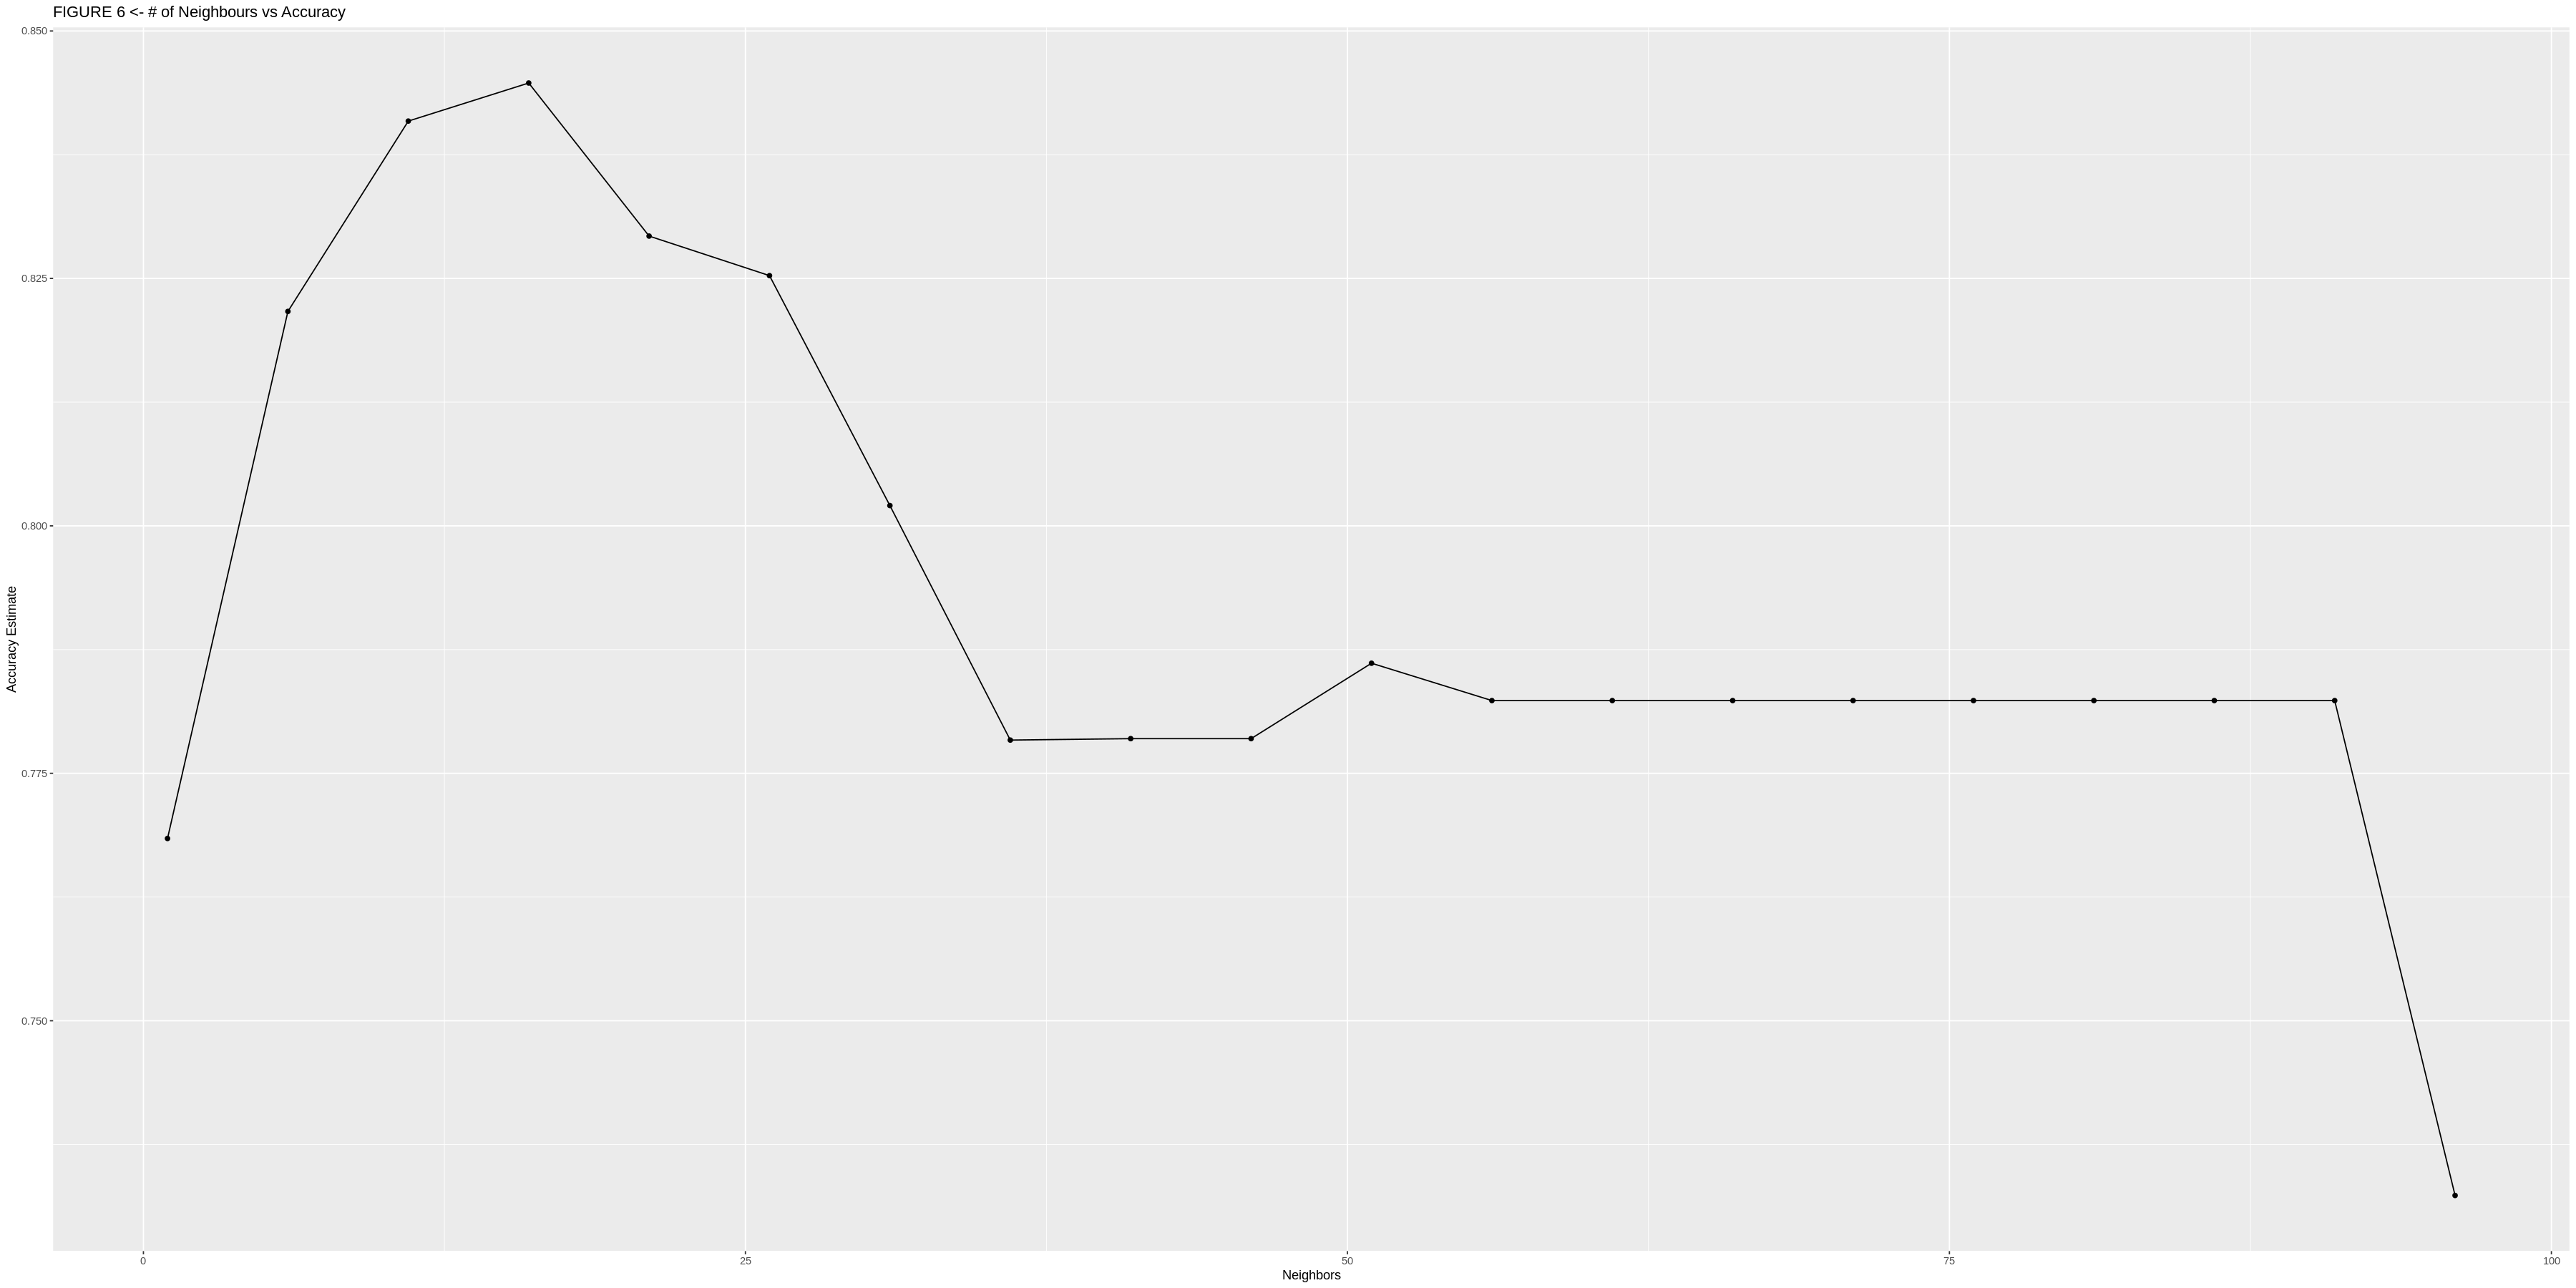

In [16]:
set.seed(1)
# Plot accuracy of each K to decide on best K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle('FIGURE 6 <- # of Neighbours vs Accuracy')

accuracy_vs_k

# Select the best K
best_k <- accuracies %>%
    select(mean, neighbors) %>%
    arrange(desc(mean)) %>%
    slice(1)

best_k
print('The best K value is 16')

In [17]:
set.seed(1)
# Now that we know our K = 16, we train the model again using K = 16

# Make model specification using 16 neighbors
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 16) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# Fit model specification to our training data
knn_fit <- knn_spec %>%
    fit(UNS ~ PEG, data = training_data)

### Model Testing 
**We tried using the textbooks method of metrics, but the factor values were different, so we decided to use the manual method instead**

In [18]:
# Set the seed
set.seed(1)

# Predict testing_data using knn_fit model
predict_testing <- predict(knn_fit, testing_data)

# Select the UNS column from testing data and bind the columns
# of our predictions to it
comparison <- testing_data %>%
    select(UNS) %>%
    bind_cols(predict_testing)

# Make a new tibble thats just the truth AKA UNS
truth <- comparison %>%
    select(UNS)

# Make a new tibble thats just the prediction AKA .pred_class
pred <- comparison %>%
    select(.pred_class)

# Calculate our models' accuracy in predicting the testing data
print('The accuracy of our model when predicting UNS classes of the testing data is:')
sum(pred==truth) / length(pred[[1]])

[1] "The accuracy of our model when predicting UNS classes of the testing data is:"


[1] 0.8689655

In [19]:
set.seed(1)
# Make four new observations of different PEGs (exam scores) that are unseen by the model 
high <- tibble(PEG = 0.7)
mid <- tibble(PEG = 0.4)
low <- tibble(PEG = 0.2)
very_low <- tibble(PEG = 0.0)

# Make predictions
print('Four UNS predictions using our made up PEG scores')
predict(knn_fit, high)
predict(knn_fit, mid)
predict(knn_fit, low)
predict(knn_fit, very_low)

[1] "Four UNS predictions using our made up PEG scores"


.pred_class
<fct>
High


.pred_class
<fct>
Middle


.pred_class
<fct>
Low


.pred_class
<fct>
very_low


### Visualization

`summarise()` ungrouping output (override with `.groups` argument)



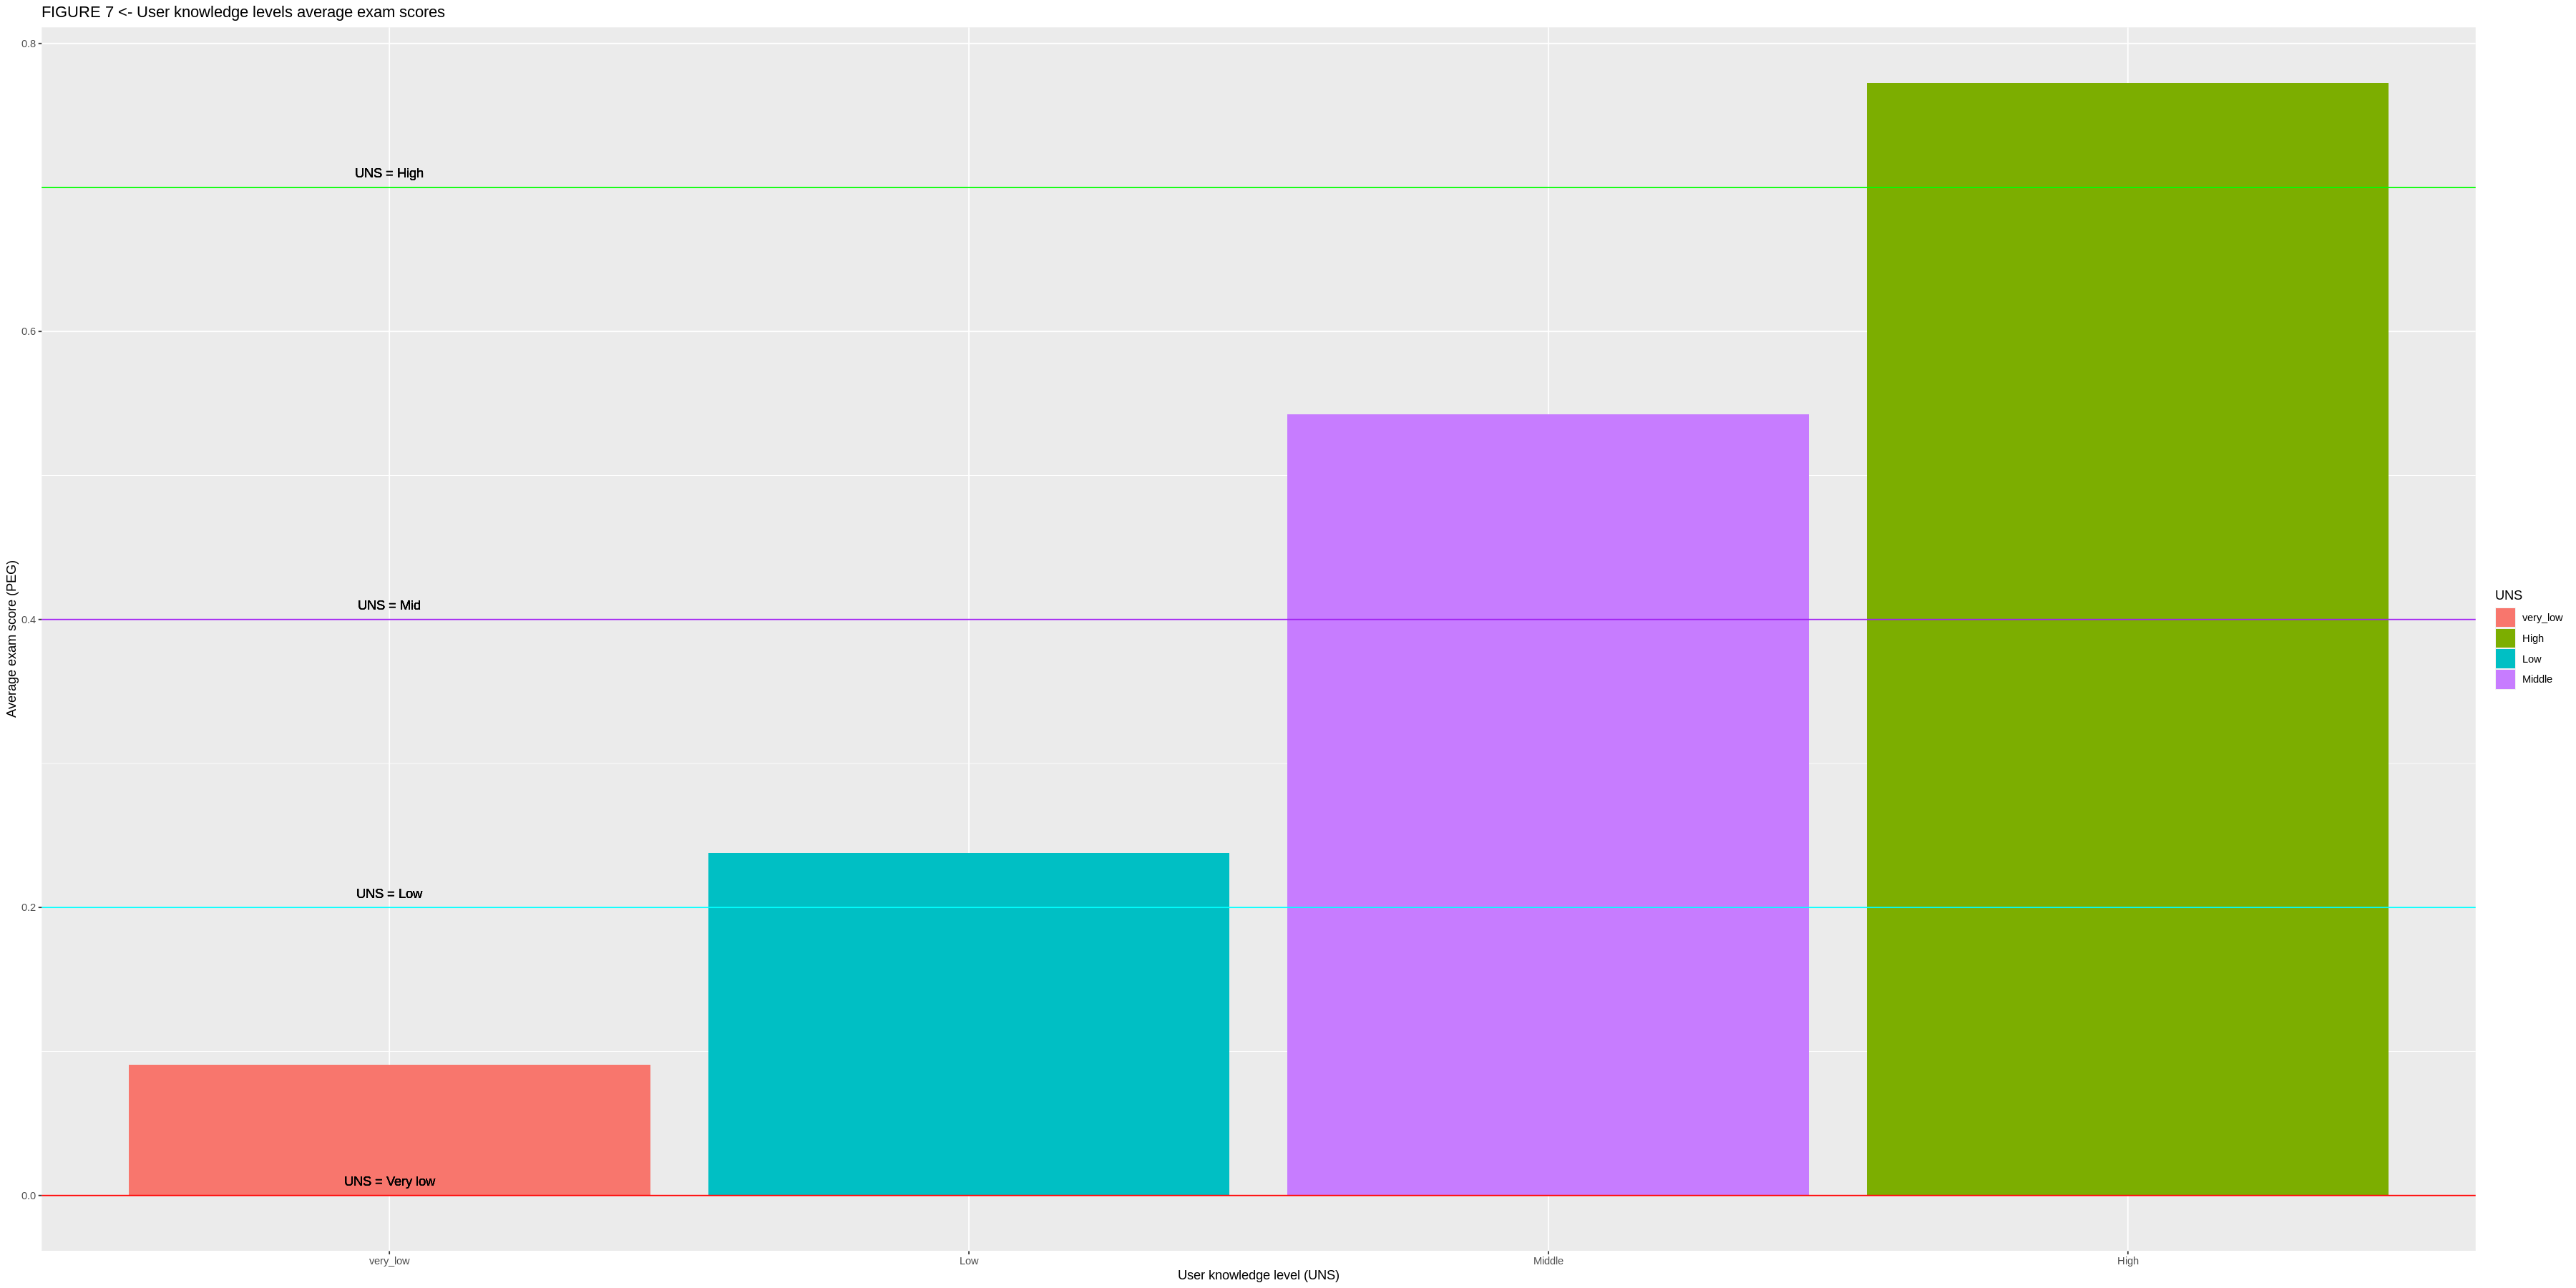

In [21]:
set.seed(1)
# To create a model visualization, display each UNS as a bar on x- axis 
# And average PEG on the y-axis
average_UNS <- training_data %>%
    select('UNS', 'PEG') %>% # select the columns we need
    group_by(UNS) %>% # group_by each UNS class
    summarize(average_PEG = mean(PEG)) %>% # find the average PEG
    arrange(desc(average_PEG))

# Plot the bars, re-ordering the bars in increasing order
# Plot horizontal lines of the exam scores, the bar it strikes first will be the users' knowledge level

model_visualization <- average_UNS %>%
    ggplot(aes(fct_reorder(UNS, average_PEG), average_PEG, fill = UNS)) +
    geom_bar(position = 'stack', stat = 'identity') + 
    geom_hline(yintercept = high[[1]], col = 'Green') +
    geom_hline(yintercept = mid[[1]], col = 'Purple') +
    geom_hline(yintercept = low[[1]], col = 'Cyan') +
    geom_hline(yintercept = very_low[[1]], col = 'Red') +
    geom_text(aes(1, high[[1]] + 0.01, label = 'UNS = High')) +
    geom_text(aes(1, mid[[1]] + 0.01, label = 'UNS = Mid')) +
    geom_text(aes(1, low[[1]] + 0.01, label = 'UNS = Low')) +
    geom_text(aes(1, very_low[[1]] + 0.01, label = 'UNS = Very low')) +
    xlab('User knowledge level (UNS)') +
    ylab('Average exam score (PEG)') +
    ggtitle('FIGURE 7 <- User knowledge levels average exam scores')
    
# Average_UNS
model_visualization

### Results and Discussion

Through our data analysis of the User Knowledge dataset, we were able to build a K-NN classifier which had an optimal K = 16 number of neighbours with a final 86.90% accuracy. This accuracy value indicates that our model is able to correctly label the knowledge level of a user based on their exam score approximately 87% of the time, and it mislabels their knowledge level close to 13% of the time. On average, those with exam scores within the range of around 0-0.1 are predicted to have a knowledge level (UNS) very low, those with 0.1-0.25 low, those with 0.25-0.55 middle and those with 0.55-0.78 a high knowledge level.

Based on our preliminary exploratory analysis, we had believed that due to the higher correlation between PEG and UNS (as compared to other variables in the dataset), that our model would produce a higher overall accuracy in its predictions. In fact, we opted to use only one variable in our model (PEG) to predict UNS because we expected this would reduce the noise in the classifier and allow it to make more accurate predictions. However, we have also learned through this analysis that it is difficult to interpret the accuracy value of our model until it has been applied in a real-life context within the world. Whether our model is truly “good” or “bad” at classifying a user’s knowledge level based on their exam scores is dependent on the situation in which it is used in, how often it mislabels UNS,  and the potential impacts/consequences of its errors in labeling UNS. 

The classifier we have created, and the findings of our data analysis have both foreseeable positive and negative impacts. Our model has the potential to be applied in a professional sense within the corporate world, to be used by recruitment teams to select the best candidates for a position in their company, based on the exam scores, and thus knowledge level of those candidates. The model could be another tool for hiring departments to filter through applicants with lower or higher knowledge levels and could easily be included as a part of the candidate selection process. The application of the model would make hiring processes easier as it would mean less manual sorting of candidate profiles and would therefore be very efficient, time-saving and potentially even cost-effective. However, the real-world use of our classifier could also have negative impacts for both potential job candidates and employers. Since this model only considers one aspect of an individual's knowledge (PEG) to classify their intelligence, the use of the classifier by hiring teams could be disadvantageous for applicants who had unfortunate, lower exam scores that do not reflect their complete knowledge level. Exam scores are also not the only, or even best, indicator of an individual’s knowledge level, since human beings display their intelligence in many other aspects of their personalities. Additionally, if the model mislabels knowledge levels of candidates more often than not, companies would be missing out on potentially excellent employees. Therefore, there is a possibility for negative implications for applicants losing job opportunities and recruitment teams overlooking good candidates. 

**Future Questions:**

How do different combinations of predictors affect the accuracy of the model? 

Is there a possibility that using another variable in this dataset, or an amalgamation of variables would produce a more accurate model?

Is it more beneficial in the real-world to predict variables such as PEG based on knowledge levels/other variables in the dataset?

Do the other variables have correlation between each other? ie. STR vs LRP?

Could a regression model be used instead by changing UNS levels to numberical values? Would the results be different?

### References
1. Masrofin, F. (2019, October 28). KMeans clustering for user knowledge data. Kaggle. Retrieved December 5, 2021, from https://www.kaggle.com/fafiliam/kmeans-clustering-for-user-knowledge-data. 
2. Timbers, T.-A., Campbell, T., & Lee, M. (2021, November 18). Data science: A first introduction. Retrieved December 5, 2021, from https://ubc-dsci.github.io/introduction-to-datascience/. 
3. Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. Knowledge-Based Systems, 37, 283–295. Retrieved December 5, 2021, from https://doi.org/10.1016/J.KNOSYS.2012.08.009 